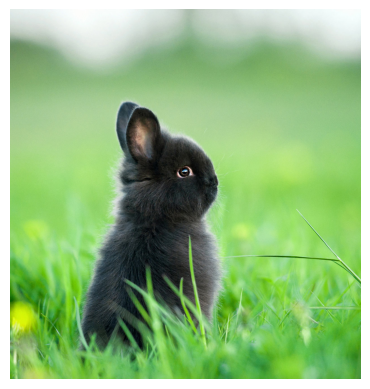

In [5]:
from PIL import Image

import matplotlib.pyplot as plt

img_path = r"C:\Users\lobster\Downloads\Zwergkaninchen\Zwergkaninchen_0001_ok.jpg"
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

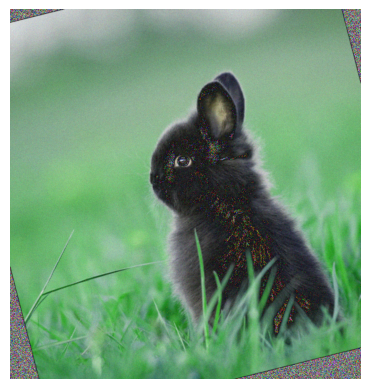

In [7]:
import torch


import torchvision.transforms as T

# Toggle variables for augmentation principles
use_hflip = True
use_rotation = True
use_crop = True
use_brightness_contrast = True
use_hue_saturation = True
use_gaussian_blur = True
use_gaussian_noise = True

# Compose the list of transforms based on toggles
transforms_list = []

if use_hflip:
    transforms_list.append(T.RandomHorizontalFlip(p=1.0))
if use_rotation:
    transforms_list.append(T.RandomRotation(degrees=(10, 15)))
if use_crop:
    transforms_list.append(T.RandomResizedCrop(size=img.size[::-1], scale=(0.8, 1.0)))
if use_brightness_contrast:
    transforms_list.append(T.ColorJitter(brightness=0.3, contrast=0.3))
if use_hue_saturation:
    transforms_list.append(T.ColorJitter(hue=0.1, saturation=0.3))
if use_gaussian_blur:
    transforms_list.append(T.GaussianBlur(kernel_size=5))
if use_gaussian_noise:
    class AddGaussianNoise(object):
        def __init__(self, mean=0., std=0.05):
            self.mean = mean
            self.std = std
        def __call__(self, tensor):
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        def __repr__(self):
            return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'
    transforms_list.append(T.ToTensor())
    transforms_list.append(AddGaussianNoise(0., 0.05))
    transforms_list.append(T.ToPILImage())
else:
    transforms_list.append(T.ToTensor())
    transforms_list.append(T.ToPILImage())

# Compose all selected transforms
transform = T.Compose(transforms_list)

# Apply the composed transform to the image
augmented_img = transform(img)

# Show the augmented image
plt.imshow(augmented_img)
plt.axis('off')
plt.show()

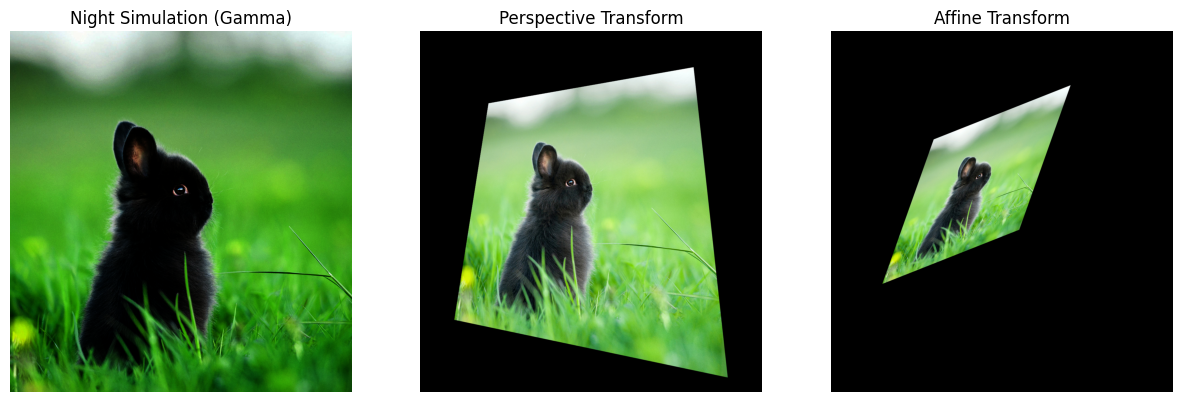

In [6]:
import cv2
import numpy as np

# Toggle variables for each transformation
use_night_simulation = True
use_perspective_transform = True
use_affine_transform = True

# Intensity variables
gamma_value = 0.4  # Lower = darker (night simulation)
perspective_intensity = 0.2  # 0 = no shift, up to ~0.4 for strong effect
affine_intensity = 0.3  # 0 = no shift, up to ~0.3 for strong effect


# Update transformation functions to use intensity variables
def adjust_gamma(image, gamma):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    inv_gamma = 1.0 / gamma
    table = [((i / 255.0) ** inv_gamma) * 255 for i in range(256)]
    table = np.array(table).astype("uint8")
    r, g, b = image.split()
    r = r.point(table)
    g = g.point(table)
    b = b.point(table)
    return Image.merge('RGB', (r, g, b))

def perspective_transform(image, intensity):
    width, height = image.size
    src = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    dst = np.float32([
        [width*intensity, height*intensity],
        [width*(1-intensity), height*intensity*0.5],
        [width*intensity*0.5, height*(1-intensity)],
        [width*(1-intensity*0.5), height*(1-intensity*0.2)]
    ])
    matrix = cv2.getPerspectiveTransform(src, dst)
    img_np = np.array(image)
    warped = cv2.warpPerspective(img_np, matrix, (width, height))
    return Image.fromarray(warped)

def affine_transform(image, intensity):
    width, height = image.size
    src = np.float32([[0, 0], [width-1, 0], [0, height-1]])
    dst = np.float32([
        [width*intensity, height*intensity],
        [width*(1-intensity), height*intensity*0.5],
        [width*intensity*0.5, height*(1-intensity)]
    ])
    matrix = cv2.getAffineTransform(src, dst)
    img_np = np.array(image)
    warped = cv2.warpAffine(img_np, matrix, (width, height))
    return Image.fromarray(warped)



# Apply transformations based on toggles and intensity variables
if use_night_simulation:
    night_img = adjust_gamma(img, gamma_value)
else:
    night_img = img

if use_perspective_transform:
    perspective_img = perspective_transform(img, perspective_intensity)
else:
    perspective_img = img

if use_affine_transform:
    affine_img = affine_transform(img, affine_intensity)
else:
    affine_img = img

# Show results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(night_img)
axs[0].set_title('Night Simulation (Gamma)')
axs[0].axis('off')
axs[1].imshow(perspective_img)
axs[1].set_title('Perspective Transform')
axs[1].axis('off')
axs[2].imshow(affine_img)
axs[2].set_title('Affine Transform')
axs[2].axis('off')
plt.show()